In [ ]:
# data from http://grouplens.org/datasets/movielens/

In [1]:
import os
data_folder = os.path.join(".", "Data", "ml-100k")
ratings_filename = os.path.join(data_folder, "u.data")

In [2]:
import pandas as pd

In [3]:
all_ratings = pd.read_csv(ratings_filename, delimiter="\t", header=None, names = ["UserID", "MovieID", "Rating", "Datetime"])
all_ratings["Datetime"] = pd.to_datetime(all_ratings['Datetime'],unit='s')
all_ratings[:5]

,UserID,MovieID,Rating,Datetime
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22
2,22,377,1,1997-11-07 07:18:36
3,244,51,2,1997-11-27 05:02:03
4,166,346,1,1998-02-02 05:33:16


In [4]:
# As you can see, there are no review for most movies, such as #213
all_ratings[all_ratings["UserID"] == 675].sort_values("MovieID")  

,UserID,MovieID,Rating,Datetime
81098,675,86,4,1998-03-10 00:26:14
90696,675,223,1,1998-03-10 00:35:51
92650,675,235,1,1998-03-10 00:35:51
95459,675,242,4,1998-03-10 00:08:42
82845,675,244,3,1998-03-10 00:29:35
53293,675,258,3,1998-03-10 00:11:19
97286,675,269,5,1998-03-10 00:08:07
93720,675,272,3,1998-03-10 00:07:11
73389,675,286,4,1998-03-10 00:07:11
77524,675,303,5,1998-03-10 00:08:42


In [5]:
# Not all reviews are favourable! Our goal is "other recommended books", so we only want favourable reviews
all_ratings["Favorable"] = all_ratings["Rating"] > 3
all_ratings[10:15]

,UserID,MovieID,Rating,Datetime,Favorable
10,62,257,2,1997-11-12 22:07:14,False
11,286,1014,5,1997-11-17 15:38:45,True
12,200,222,5,1997-10-05 09:05:40,True
13,210,40,3,1998-03-27 21:59:54,False
14,224,29,3,1998-02-21 23:40:57,False


In [6]:
all_ratings[all_ratings["UserID"] == 1][:5]

,UserID,MovieID,Rating,Datetime,Favorable
202,1,61,4,1997-11-03 07:33:40,True
305,1,189,3,1998-03-01 06:15:28,False
333,1,33,4,1997-11-03 07:38:19,True
334,1,160,4,1997-09-24 03:42:27,True
478,1,20,4,1998-02-14 04:51:23,True


In [7]:
all_ratings.UserID.nunique()

943

In [8]:
# Sample the dataset. You can try increasing the size of the sample, but the run time will be considerably longer
ratings = all_ratings[all_ratings['UserID'].isin(range(200))]  # & ratings["UserID"].isin(range(100))]

In [9]:
# We start by creating a dataset of each user's favourable reviews
favorable_ratings = ratings[ratings["Favorable"]]
favorable_ratings[:5]

,UserID,MovieID,Rating,Datetime,Favorable
16,122,387,5,1997-11-11 17:47:39,True
20,119,392,4,1998-01-30 16:13:34,True
21,167,486,4,1998-04-16 14:54:12,True
26,38,95,5,1998-04-13 01:14:54,True
28,63,277,4,1997-10-01 23:10:01,True


In [10]:
# We are only interested in the reviewers who have more than one review
favorable_reviews_by_users = dict((k, frozenset(v.values)) for k, v in favorable_ratings.groupby("UserID")["MovieID"])
len(favorable_reviews_by_users)

199

In [11]:
# Find out how many movies have favourable ratings
num_favorable_by_movie = ratings[["MovieID", "Favorable"]].groupby("MovieID").sum()
num_favorable_by_movie.sort_values("Favorable", ascending=False)[:5]

,Favorable
MovieID,
50,100
100,89
258,83
181,79
174,74


In [12]:
from collections import defaultdict

def find_frequent_itemsets(favorable_reviews_by_users, k_1_itemsets, min_support):
    counts = defaultdict(int)
    for user, reviews in favorable_reviews_by_users.items():
        for itemset in k_1_itemsets:
            if itemset.issubset(reviews):
                for other_reviewed_movie in reviews - itemset:
                    current_superset = itemset | frozenset((other_reviewed_movie,))
                    counts[current_superset] += 1
    return dict([(itemset, frequency) for itemset, frequency in counts.items() if frequency >= min_support])

In [13]:
import sys
frequent_itemsets = {}  # itemsets are sorted by length
min_support = 50

# k=1 candidates are the isbns with more than min_support favourable reviews
frequent_itemsets[1] = dict((frozenset((movie_id,)), row["Favorable"])
                                for movie_id, row in num_favorable_by_movie.iterrows()
                                if row["Favorable"] > min_support)

print("There are {} movies with more than {} favorable reviews".format(len(frequent_itemsets[1]), min_support))
sys.stdout.flush()
for k in range(2, 20):
    # Generate candidates of length k, using the frequent itemsets of length k-1
    # Only store the frequent itemsets
    cur_frequent_itemsets = find_frequent_itemsets(favorable_reviews_by_users, frequent_itemsets[k-1],
                                                   min_support)
    if len(cur_frequent_itemsets) == 0:
        print("Did not find any frequent itemsets of length {}".format(k))
        sys.stdout.flush()
        break
    else:
        print("I found {} frequent itemsets of length {}".format(len(cur_frequent_itemsets), k))
        #print(cur_frequent_itemsets)
        sys.stdout.flush()
        frequent_itemsets[k] = cur_frequent_itemsets
# We aren't interested in the itemsets of length 1, so remove those
del frequent_itemsets[1]

There are 16 movies with more than 50 favorable reviews
I found 93 frequent itemsets of length 2
I found 295 frequent itemsets of length 3
I found 593 frequent itemsets of length 4
I found 785 frequent itemsets of length 5
I found 677 frequent itemsets of length 6
I found 373 frequent itemsets of length 7
I found 126 frequent itemsets of length 8
I found 24 frequent itemsets of length 9
I found 2 frequent itemsets of length 10
Did not find any frequent itemsets of length 11


In [14]:
print("Found a total of {0} frequent itemsets".format(sum(len(itemsets) for itemsets in frequent_itemsets.values())))

Found a total of 2968 frequent itemsets


In [41]:
# Now we create the association rules. First, they are candidates until the confidence has been tested
candidate_rules = []
for itemset_length, itemset_counts in frequent_itemsets.items():
    for itemset in itemset_counts.keys():
        for conclusion in itemset:
            premise = itemset - set((conclusion,))
            candidate_rules.append((premise, conclusion))
print("There are {} candidate rules".format(len(candidate_rules)))

There are 15285 candidate rules


In [16]:
print(candidate_rules[:5])

[(frozenset({7}), 1), (frozenset({1}), 7), (frozenset({50}), 1), (frozenset({1}), 50), (frozenset({1}), 56)]


In [42]:
# save the rules to a file
import csv
with open("candidate_rules.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(candidate_rules)

In [49]:
# Now, we compute the confidence of each of these rules. This is very similar to what we did in chapter 1
correct_counts = defaultdict(int)
incorrect_counts = defaultdict(int)
for user, reviews in favorable_reviews_by_users.items():
    for candidate_rule in candidate_rules:
        premise, conclusion = candidate_rule
        if premise.issubset(reviews):
            if conclusion in reviews:
                correct_counts[candidate_rule] += 1
            else:
                incorrect_counts[candidate_rule] += 1
rule_confidence = {candidate_rule: correct_counts[candidate_rule] / float(correct_counts[candidate_rule] + incorrect_counts[candidate_rule])
              for candidate_rule in candidate_rules}

In [50]:
# Choose only rules above a minimum confidence level
min_confidence = 0.9

In [51]:
# Filter out the rules with poor confidence
rule_confidence = {rule: confidence for rule, confidence in rule_confidence.items() if confidence > min_confidence}
print(len(rule_confidence))

5152


In [52]:
from operator import itemgetter
sorted_confidence = sorted(rule_confidence.items(), key=itemgetter(1), reverse=True)

In [53]:
# find the top 10 rules with the highest confidence
top_confidence = sorted_confidence[:10]

In [58]:
# find the support for each of these rules
counts = defaultdict(int)
for user, reviews in favorable_reviews_by_users.items():
    for rule, confidence in top_confidence:
        premise, conclusion = rule
        if premise.issubset(reviews) and conclusion in reviews:
            counts[rule] += 1
top_support = {rule: support / len(favorable_reviews_by_users) for rule, support in counts.items()}

In [63]:
top_confidence_dict = {}
for rule, confidence in top_confidence:
    top_confidence_dict[rule] = confidence

In [64]:
# find the lift for each of these rules
conclusion_counts = defaultdict(int)
for user, reviews in favorable_reviews_by_users.items():
    for rule, confidence in top_confidence:
        premise, conclusion = rule
        if conclusion in reviews:
            conclusion_counts[rule] += 1
top_lift = {rule: top_confidence_dict[rule] / (count / len(favorable_reviews_by_users)) for rule, count in conclusion_counts.items()}

In [66]:
top_support_dict = {}
for rule, support in top_support.items():
    top_support_dict[rule] = support

top_lift_dict = {}
for rule, lift in top_lift.items():
    top_lift_dict[rule] = lift

In [67]:
# find the Chi-Square for each of these rules
import numpy as np
from scipy.stats import chi2_contingency
chi2 = defaultdict(int)
for rule, confidence in top_confidence:
    premise, conclusion = rule
    observed = np.array([[correct_counts[rule], incorrect_counts[rule]],
                         [conclusion_counts[rule] - correct_counts[rule],
                          len(favorable_reviews_by_users) - conclusion_counts[rule] - incorrect_counts[rule]]])
    chi2[rule] = chi2_contingency(observed)[0]

In [69]:
# find Kulczynski for each of these rules
kulczynski = defaultdict(int)
for rule, confidence in top_confidence:
    premise, conclusion = rule
    kulczynski[rule] = (correct_counts[rule] / (correct_counts[rule] + incorrect_counts[rule])) + (correct_counts[rule] / conclusion_counts[rule])
    kulczynski[rule] /= 2

In [70]:
# find cosine for each of these rules
cosine = defaultdict(int)
for rule, confidence in top_confidence:
    premise, conclusion = rule
    cosine[rule] = correct_counts[rule] / np.sqrt(conclusion_counts[rule] * (correct_counts[rule] + incorrect_counts[rule]))

In [71]:
# find all-confidence for each of these rules
all_confidence = defaultdict(int)
for rule, confidence in top_confidence:
    premise, conclusion = rule
    all_confidence[rule] = correct_counts[rule] / (correct_counts[rule] + incorrect_counts[rule] + conclusion_counts[rule] - correct_counts[rule])

In [72]:
# find max-confidence for each of these rules
max_confidence = defaultdict(int)
for rule, confidence in top_confidence:
    premise, conclusion = rule
    max_confidence[rule] = max(correct_counts[rule] / (correct_counts[rule] + incorrect_counts[rule]),
                               correct_counts[rule] / conclusion_counts[rule])

In [84]:
# combine confidence and support, lift, Chi-Square, Kulczynski, cosine, all-confidence, max-confidence
# into a single data frame
import pandas as pd
df = pd.DataFrame.from_dict(top_confidence_dict, orient='index')
df = df.rename(columns={0: 'confidence'})
df['support'] = pd.Series(top_support_dict)
df['lift'] = pd.Series(top_lift_dict)
df['chi2'] = pd.Series(chi2)
df['kulczynski'] = pd.Series(kulczynski)
df['cosine'] = pd.Series(cosine)
df['all_confidence'] = pd.Series(all_confidence)
df['max_confidence'] = pd.Series(max_confidence)
df = df.sort_values(by='confidence', ascending=False)
df

,confidence,support,lift,chi2,kulczynski,cosine,all_confidence,max_confidence
"((98, 181), 50)",1.0,0.170854,1.990000,38.231413,0.670000,0.583095,0.340000,1.0
"((172, 79), 174)",1.0,0.170854,2.689189,66.061635,0.729730,0.677834,0.459459,1.0
"((258, 172), 174)",1.0,0.140704,2.689189,51.956844,0.689189,0.615125,0.378378,1.0
"((1, 181, 7), 50)",1.0,0.105528,1.990000,21.071216,0.605000,0.458258,0.210000,1.0
"((1, 172, 7), 174)",1.0,0.100503,2.689189,34.628345,0.635135,0.519875,0.270270,1.0
"((56, 1, 50), 174)",1.0,0.130653,2.689189,47.473457,0.675676,0.592749,0.351351,1.0
"((56, 1, 181), 50)",1.0,0.090452,1.990000,17.465336,0.590000,0.424264,0.180000,1.0
"((1, 98, 181), 50)",1.0,0.120603,1.990000,24.802982,0.620000,0.489898,0.240000,1.0
"((1, 172, 181), 50)",1.0,0.125628,1.990000,26.075863,0.625000,0.500000,0.250000,1.0
"((56, 1, 64), 98)",1.0,0.100503,2.842857,37.875708,0.642857,0.534522,0.285714,1.0


In [22]:
for index in range(5):
    print("Rule #{0}".format(index + 1))
    (premise, conclusion) = sorted_confidence[index][0]
    print("Rule: If a person recommends {0} they will also recommend {1}".format(premise, conclusion))
    print(" - Confidence: {0:.3f}".format(rule_confidence[(premise, conclusion)]))
    print("")

Rule #1
Rule: If a person recommends frozenset({98, 181}) they will also recommend 50
 - Confidence: 1.000

Rule #2
Rule: If a person recommends frozenset({172, 79}) they will also recommend 174
 - Confidence: 1.000

Rule #3
Rule: If a person recommends frozenset({258, 172}) they will also recommend 174
 - Confidence: 1.000

Rule #4
Rule: If a person recommends frozenset({1, 181, 7}) they will also recommend 50
 - Confidence: 1.000

Rule #5
Rule: If a person recommends frozenset({1, 172, 7}) they will also recommend 174
 - Confidence: 1.000



In [23]:
# Even better, we can get the movie titles themselves from the dataset
movie_name_filename = os.path.join(data_folder, "u.item")
movie_name_data = pd.read_csv(movie_name_filename, delimiter="|", header=None, encoding = "mac-roman")
movie_name_data.columns = ["MovieID", "Title", "Release Date", "Video Release", "IMDB", "<UNK>", "Action", "Adventure",
                           "Animation", "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir",
                           "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]

In [24]:
def get_movie_name(movie_id):
    title_object = movie_name_data[movie_name_data["MovieID"] == movie_id]["Title"]
    title = title_object.values[0]
    return title

In [25]:
get_movie_name(4)

'Get Shorty (1995)'

In [26]:
for index in range(5):
    print("Rule #{0}".format(index + 1))
    (premise, conclusion) = sorted_confidence[index][0]
    premise_names = ", ".join(get_movie_name(idx) for idx in premise)
    conclusion_name = get_movie_name(conclusion)
    print("Rule: If a person recommends {0} they will also recommend {1}".format(premise_names, conclusion_name))
    print(" - Confidence: {0:.3f}".format(rule_confidence[(premise, conclusion)]))
    print("")

Rule #1
Rule: If a person recommends Silence of the Lambs, The (1991), Return of the Jedi (1983) they will also recommend Star Wars (1977)
 - Confidence: 1.000

Rule #2
Rule: If a person recommends Empire Strikes Back, The (1980), Fugitive, The (1993) they will also recommend Raiders of the Lost Ark (1981)
 - Confidence: 1.000

Rule #3
Rule: If a person recommends Contact (1997), Empire Strikes Back, The (1980) they will also recommend Raiders of the Lost Ark (1981)
 - Confidence: 1.000

Rule #4
Rule: If a person recommends Toy Story (1995), Return of the Jedi (1983), Twelve Monkeys (1995) they will also recommend Star Wars (1977)
 - Confidence: 1.000

Rule #5
Rule: If a person recommends Toy Story (1995), Empire Strikes Back, The (1980), Twelve Monkeys (1995) they will also recommend Raiders of the Lost Ark (1981)
 - Confidence: 1.000



In [27]:
# Evaluation using test data
test_dataset = all_ratings[~all_ratings['UserID'].isin(range(200))]
test_favorable = test_dataset[test_dataset["Favorable"]]
#test_not_favourable = test_dataset[~test_dataset["Favourable"]]
test_favorable_by_users = dict((k, frozenset(v.values)) for k, v in test_favorable.groupby("UserID")["MovieID"])
#test_not_favourable_by_users = dict((k, frozenset(v.values)) for k, v in test_not_favourable.groupby("UserID")["MovieID"])
#test_users = test_dataset["UserID"].unique()

In [28]:
test_dataset[:5]

,UserID,MovieID,Rating,Datetime,Favorable
3,244,51,2,1997-11-27 05:02:03,False
5,298,474,4,1998-01-07 14:20:06,True
7,253,465,5,1998-04-03 18:34:27,True
8,305,451,3,1998-02-01 09:20:17,False
11,286,1014,5,1997-11-17 15:38:45,True


In [29]:
correct_counts = defaultdict(int)
incorrect_counts = defaultdict(int)
for user, reviews in test_favorable_by_users.items():
    for candidate_rule in candidate_rules:
        premise, conclusion = candidate_rule
        if premise.issubset(reviews):
            if conclusion in reviews:
                correct_counts[candidate_rule] += 1
            else:
                incorrect_counts[candidate_rule] += 1

In [74]:
correct_counts = defaultdict(int)
incorrect_counts = defaultdict(int)
for user, reviews in test_favorable_by_users.items():
    for candidate_rule, confidence in top_confidence:
        premise, conclusion = candidate_rule
        if premise.issubset(reviews):
            if conclusion in reviews:
                correct_counts[candidate_rule] += 1
            else:
                incorrect_counts[candidate_rule] += 1

In [80]:
test_confidence = {}
for candidate_rule, confidence in top_confidence:
    correct_count = correct_counts[candidate_rule]
    incorrect_count = incorrect_counts[candidate_rule]
    test_confidence[candidate_rule] = correct_count / float(correct_count + incorrect_count)

In [85]:
df['test_confidence'] = pd.Series(test_confidence)
df

,confidence,support,lift,chi2,kulczynski,cosine,all_confidence,max_confidence,test_confidence
"((98, 181), 50)",1.0,0.170854,1.990000,38.231413,0.670000,0.583095,0.340000,1.0,0.935897
"((172, 79), 174)",1.0,0.170854,2.689189,66.061635,0.729730,0.677834,0.459459,1.0,0.875912
"((258, 172), 174)",1.0,0.140704,2.689189,51.956844,0.689189,0.615125,0.378378,1.0,0.840909
"((1, 181, 7), 50)",1.0,0.105528,1.990000,21.071216,0.605000,0.458258,0.210000,1.0,0.932432
"((1, 172, 7), 174)",1.0,0.100503,2.689189,34.628345,0.635135,0.519875,0.270270,1.0,0.903226
"((56, 1, 50), 174)",1.0,0.130653,2.689189,47.473457,0.675676,0.592749,0.351351,1.0,0.816092
"((56, 1, 181), 50)",1.0,0.090452,1.990000,17.465336,0.590000,0.424264,0.180000,1.0,0.969697
"((1, 98, 181), 50)",1.0,0.120603,1.990000,24.802982,0.620000,0.489898,0.240000,1.0,0.932584
"((1, 172, 181), 50)",1.0,0.125628,1.990000,26.075863,0.625000,0.500000,0.250000,1.0,0.970588
"((56, 1, 64), 98)",1.0,0.100503,2.842857,37.875708,0.642857,0.534522,0.285714,1.0,0.794118


<Axes: title={'center': 'Confidence vs Test Confidence'}>

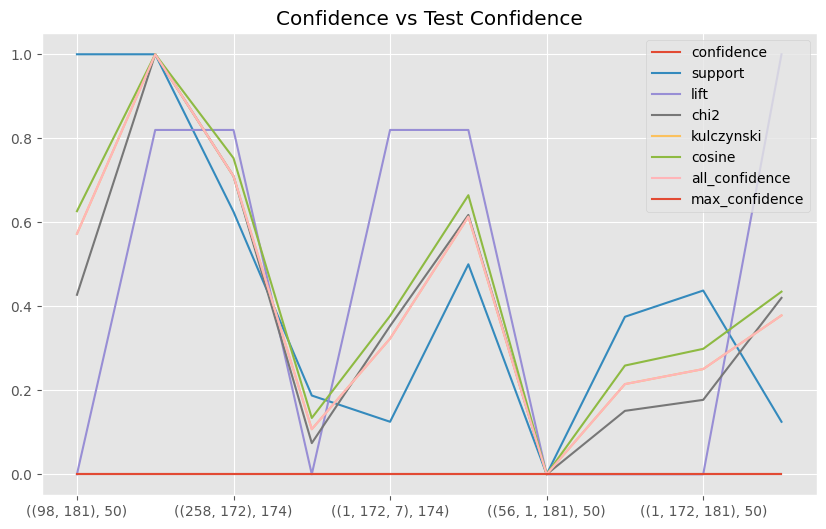

In [93]:
# draw a line chart to compare each column in the data frame
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# scale the data frame columns to [0, 1] for better visualization
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
scaled_df = min_max_scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df, index=df.index, columns=df.columns)

scaled_df.drop(['test_confidence'], axis=1).plot(kind='line', figsize=(10, 6), title='Confidence vs Test Confidence')


In [75]:
test_confidence = {candidate_rule: correct_counts[candidate_rule] / float(correct_counts[candidate_rule] + incorrect_counts[candidate_rule])
                   for candidate_rule in rule_confidence}
print(len(test_confidence))

ZeroDivisionError: float division by zero

In [31]:
sorted_test_confidence = sorted(test_confidence.items(), key=itemgetter(1), reverse=True)
print(sorted_test_confidence[:5])

[((frozenset({64, 1, 7, 79, 50}), 174), 1.0), ((frozenset({64, 1, 98, 7, 79}), 174), 1.0), ((frozenset({64, 1, 7, 172, 79}), 174), 1.0), ((frozenset({64, 1, 7, 79, 181}), 174), 1.0), ((frozenset({64, 1, 172, 79, 56}), 174), 1.0)]


In [32]:
for index in range(10):
    print("Rule #{0}".format(index + 1))
    (premise, conclusion) = sorted_confidence[index][0]
    premise_names = ", ".join(get_movie_name(idx) for idx in premise)
    conclusion_name = get_movie_name(conclusion)
    print("Rule: If a person recommends {0} they will also recommend {1}".format(premise_names, conclusion_name))
    print(" - Train Confidence: {0:.3f}".format(rule_confidence.get((premise, conclusion), -1)))
    print(" - Test Confidence: {0:.3f}".format(test_confidence.get((premise, conclusion), -1)))
    print("")

Rule #1
Rule: If a person recommends Silence of the Lambs, The (1991), Return of the Jedi (1983) they will also recommend Star Wars (1977)
 - Train Confidence: 1.000
 - Test Confidence: 0.936

Rule #2
Rule: If a person recommends Empire Strikes Back, The (1980), Fugitive, The (1993) they will also recommend Raiders of the Lost Ark (1981)
 - Train Confidence: 1.000
 - Test Confidence: 0.876

Rule #3
Rule: If a person recommends Contact (1997), Empire Strikes Back, The (1980) they will also recommend Raiders of the Lost Ark (1981)
 - Train Confidence: 1.000
 - Test Confidence: 0.841

Rule #4
Rule: If a person recommends Toy Story (1995), Return of the Jedi (1983), Twelve Monkeys (1995) they will also recommend Star Wars (1977)
 - Train Confidence: 1.000
 - Test Confidence: 0.932

Rule #5
Rule: If a person recommends Toy Story (1995), Empire Strikes Back, The (1980), Twelve Monkeys (1995) they will also recommend Raiders of the Lost Ark (1981)
 - Train Confidence: 1.000
 - Test Confidence